In [11]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, grad, jit, random

import matplotlib
import matplotlib.pyplot as plt

import zarr
import xarray as xr

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [27]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
era5 = xr.open_zarr(obs_path)

In [29]:
obs_path = 'gs://weatherbench2/datasets/era5_weekly/1959-2023_01_10-1h-240x121_equiangular_with_poles_conservative.zarr'
era5 = xr.open_zarr(obs_path)

In [30]:
era5['temperature'].shape

(23386, 13, 240, 121)

In [26]:
23386 / 104

224.8653846153846

In [13]:
ntrain = 5200
nval = 2000
ntest = 2000

train = era5['temperature'][0:ntrain,-1]
val = era5['temperature'][ntrain:(ntrain+nval),-1]
test = era5['temperature'][(ntrain+nval):(ntrain+nval+ntest),-1]

In [14]:
t_train = era5['time'][0:ntrain]
t_val = era5['time'][ntrain:(ntrain+nval)]
t_test = era5['time'][(ntrain+nval):(ntrain+nval+ntest)]

dtrain = np.array(train)
dval = np.array(val)
dtest = np.array(test)

dtrain = dtrain - 273.15
dval = dval - 273.15
dtest = dtest - 273.15

In [15]:
dtrain = np.moveaxis(dtrain, 1, 2)
dtrain = np.rot90(dtrain, k = 2, axes = (1, 2))
dtrain = np.flip(dtrain, axis = 2)

dval = np.moveaxis(dval, 1, 2)
dval = np.rot90(dval, k = 2, axes = (1, 2))
dval = np.flip(dval, axis = 2)

dtest = np.moveaxis(dtest, 1, 2)
dtest = np.rot90(dtest, k = 2, axes = (1, 2))
dtest = np.flip(dtest, axis = 2)

In [16]:
# train_day = np.array(train['time']["time.dayofyear"])
# val_day = np.array(val['time']["time.dayofyear"])
# test_day = np.array(test['time']["time.dayofyear"])

# ## anomalize
# dmeans = [np.mean(dtrain[train_day == i]) for i in range(1, 367)]

# for i in trange(len(dtrain), leave = False):
#   dtrain[i] = dtrain[i] - dmeans[train_day[i]-1]

# for i in trange(len(dval), leave = False):
#   dval[i] = dval[i] - dmeans[val_day[i]-1]

# for i in trange(len(dtest), leave = False):
#   dtest[i] = dtest[i] - dmeans[test_day[i]-1]

In [17]:
# ## detrend
# t = np.linspace(0, 1, ntrain+nval+ntest)
# t1 = t[:ntrain]
# t2 = t[ntrain:(ntrain+nval)]
# t3 = t[(ntrain+nval):(ntrain+nval+ntest)]
# d = np.mean(dtrain, axis = (1, 2))

# beta = np.polyfit(t1, d, 1)
# dtrain = dtrain - np.polyval(beta, t[:ntrain])[:,None,None]
# dval = dval - np.polyval(beta, t2)[:,None,None]
# dtest = dtest - np.polyval(beta, t3)[:,None,None]

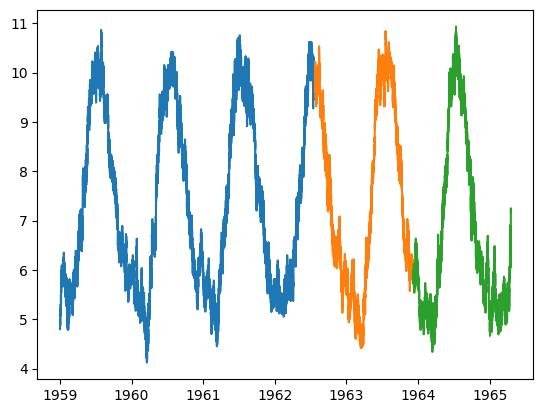

In [18]:
plt.plot(t_train, np.mean(dtrain, axis = (1, 2)))
plt.plot(t_val, np.mean(dval, axis = (1, 2)))
plt.plot(t_test, np.mean(dtest, axis = (1, 2)))

In [21]:
np.save('../data/era5_train_small.npy', dtrain)
np.save('../data/era5_val_small.npy', dval)
np.save('../data/era5_test_small.npy', dtest)